In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path  
import pytz
from utils import filter_by_column_value, plot_range_pie
#for preprocessing disruptions dataset
tz = pytz.timezone("Europe/Amsterdam")


## Plan
- See if disruptions/maintenance influences the dataset. See if disruption categories influence delays. See if disruption duration influences the dataset
- Retreive maintenance and disruptions from NS API

### Preprocessing
- Only include disruptions with the duration of 5 minutes or more (for impactfulness)
- Don't include duration - while this will help the model, we have no way of getting the duration in minutes from NS API
- Separate feature for maintenance and other disruptions
- If possible, get the clasification of disruptions

### Specific steps on merging disruptions with main dataset
- 2 new features - Maintenance and disruptions
- Maintenance - ONLY engineering works.
- Disruptions - everything else
- Potential problems - not measuring the disruptions correctly. Using the disruptions that are not shown in NS API
- Potential problems 2 - filtering by station dilema (see below)
- For now logic is simple - if there's only one station, then the disruption is localized to a station, we don't need both departure and arrival station to be included
- If there are two stations, they must be in rdt_station_codes to count.
- Observe how this affects disruption number and changes the delay split (more/less delay time)
- See also how this influences accuracy

In [38]:
disruptions = pd.read_csv('datasets/disruptions-2024.csv')
disruptions.head()

,rdt_id,ns_lines,rdt_lines,rdt_lines_id,rdt_station_names,rdt_station_codes,cause_nl,cause_en,statistical_cause_nl,statistical_cause_en,cause_group,start_time,end_time,duration_minutes
0,51320,Zwolle-Kampen,Kampen - Zwolle,49,"Kampen,Zwolle,Zwolle Stadshagen","KPN, ZL, ZLSH",problemen met de personeelsinzet,staffing problems,problemen met de personeelsinzet,staffing problems,staff,2024-01-01 07:03:51,2024-01-01 10:05:12,181.0
1,51321,Zwolle-Enschede,Almelo - Zwolle,95,"Almelo,Heino,Nijverdal,Raalte,Wierden,Zwolle","AML, HNO, NVD, RAT, WDN, ZL",problemen met de personeelsinzet,staffing problems,problemen met de personeelsinzet,staffing problems,staff,2024-01-01 07:07:34,2024-01-01 10:03:14,176.0
2,51322,Uitgeest,"Alkmaar - Amsterdam Centraal, Haarlem - Uitgeest","111,161",Uitgeest,UTG,inzet van hulpdiensten,an emergency call,inzet van hulpdiensten,an emergency call,external,2024-01-01 13:57:23,2024-01-01 14:17:16,20.0
3,51323,Rotterdam-Dordrecht,Dordrecht - Rotterdam Centraal,16,"Rotterdam Blaak,Rotterdam Centraal,Rotterdam Zuid","RTB, RTD, RTZ",brandmelding,fire alarm,brandmelding,fire alarm,external,2024-01-01 16:47:31,2024-01-01 17:55:24,68.0
4,51324,Rotterdam-Breda (HSL),Breda - Rotterdam Centraal (HSL),15,"Breda,Rotterdam Centraal","BD, RTD",brandmelding,fire alarm,brandmelding,fire alarm,external,2024-01-01 16:57:27,2024-01-01 17:55:28,58.0


In [39]:
main_dataset = pd.read_csv('preprocessed_data/preprocessed_with_stations_metadata.csv')


In [40]:
len(disruptions)

5964

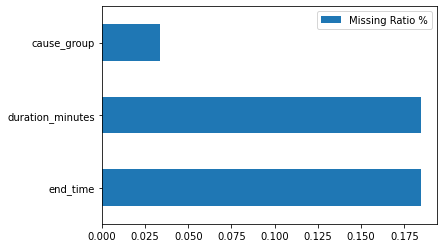

In [41]:
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NAs found')
plot_nas(disruptions)

In [42]:
disruptions = disruptions.dropna()

In [43]:
disruptions = disruptions[disruptions['duration_minutes'] > 8]
print(len(disruptions))

5296


In [44]:
def plot_bar_chart(label):
    grouped_data = disruptions.groupby(label).size()
    
    # Plot the bar chart
    grouped_data.plot(kind='bar', color='navajowhite', edgecolor='black')
    
    # Add labels and title
    plt.xlabel(label)
    plt.ylabel('Count')
    plt.title('Distribution of ' + label)
    
    # Add percentages on top of each bar
    total_count = len(disruptions)  # Total number of entries in the DataFrame
    for i, value in enumerate(grouped_data):
        percentage = (value / total_count) * 100
        plt.text(i, value + 0.1, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=8)
    
    # Show the plot
    plt.show()

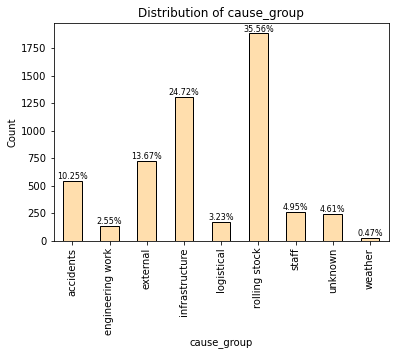

In [45]:
plot_bar_chart('cause_group')

In [46]:
disruptions["statistical_cause_en"].unique()

array(['staffing problems', 'an emergency call', 'fire alarm',
       'points failure', 'broken down train',
       'the expected weather conditions', 'collision',
       'signal and level crossing failure', 'police action',
       'strong winds on the high speed line', 'disruption elsewhere',
       'tree on the track', 'signal failure', 'hindrance on the railway',
       'problems with the rolling stock', 'flooding',
       'damaged overhead wires', 'stranded train',
       'railway problems abroad', 'signalling and points failure',
       'police investigation', 'problem in a tunnel',
       'defective railway track', 'technical investigation',
       'person on the railway track', 'level crossing failure',
       'staff strikes abroad', 'an animal on the railway track',
       'vehicle on the railway track', 'damaged railway bridge',
       'engineering works', 'over-running engineering works',
       'repair works', 'snow', 'overhead wires covered with frost',
       'power failur

In [47]:
#Don't remove "unknown" from disruptions - let's consider that it's just the "other" category, to include incidents like suicides
#Split maintenances and other disruptions into 2 separate datasets
engineering_works = disruptions[disruptions['statistical_cause_en'] == "staffing problems"]
len(engineering_works)
disruptions = disruptions[disruptions['cause_group'] != "engineering work"]

In [48]:
engineering_works.head()

,rdt_id,ns_lines,rdt_lines,rdt_lines_id,rdt_station_names,rdt_station_codes,cause_nl,cause_en,statistical_cause_nl,statistical_cause_en,cause_group,start_time,end_time,duration_minutes
0,51320,Zwolle-Kampen,Kampen - Zwolle,49,"Kampen,Zwolle,Zwolle Stadshagen","KPN, ZL, ZLSH",problemen met de personeelsinzet,staffing problems,problemen met de personeelsinzet,staffing problems,staff,2024-01-01 07:03:51,2024-01-01 10:05:12,181.0
1,51321,Zwolle-Enschede,Almelo - Zwolle,95,"Almelo,Heino,Nijverdal,Raalte,Wierden,Zwolle","AML, HNO, NVD, RAT, WDN, ZL",problemen met de personeelsinzet,staffing problems,problemen met de personeelsinzet,staffing problems,staff,2024-01-01 07:07:34,2024-01-01 10:03:14,176.0
49,51369,Heerlen-Aachen Hbf,Aachen Hbf - Heerlen,130,"Aachen Hbf,Eygelshoven Markt,Heerlen,Heerlen D...","AHBF, EGHM, HRL, HRLK, HZ, LG, AW",problemen met de personeelsinzet,staffing problems,problemen met de personeelsinzet,staffing problems,staff,2024-01-05 05:07:32,2024-01-05 12:52:55,465.0
53,51373,Heerlen-Aachen Hbf,Aachen Hbf - Heerlen,130,"Aachen Hbf,Eygelshoven Markt,Heerlen,Heerlen D...","AHBF, EGHM, HRL, HRLK, HZ, LG, AW",problemen met de personeelsinzet,staffing problems,problemen met de personeelsinzet,staffing problems,staff,2024-01-06 00:12:18,2024-01-06 05:06:22,294.0
54,51374,Roermond-Maastricht-Maastricht Randwyck,"Liège-Guillemins - Maastricht, Maastricht - Ma...","73,74,75,121","Bunde,Beek-Elsloo,Echt,Geleen-Lutterade,Maastr...","BDE, BK, EC, LUT, MT, MTR, RM, SRN, STD",problemen met de personeelsinzet,staffing problems,problemen met de personeelsinzet,staffing problems,staff,2024-01-06 01:34:09,2024-01-06 17:45:44,972.0


In [49]:
unknown_causes = disruptions[disruptions['cause_group'] == "rolling stock"]
#Keep a close eye on those. 

In [50]:
unknown_causes.head()

,rdt_id,ns_lines,rdt_lines,rdt_lines_id,rdt_station_names,rdt_station_codes,cause_nl,cause_en,statistical_cause_nl,statistical_cause_en,cause_group,start_time,end_time,duration_minutes
10,51330,Amsterdam-Schiphol-Rotterdam (HSL),"Amsterdam Centraal - Schiphol Airport, Rotterd...","24,32","Amsterdam Centraal,Amsterdam Lelylaan,Amsterda...","ASD, ASDL, ASS, RTD, SHL",defecte trein,broken down train,defecte trein,broken down train,rolling stock,2024-01-02 14:10:20,2024-01-02 17:07:40,177.0
12,51332,Schiphol-Rotterdam (HSL),Rotterdam Centraal - Schiphol Airport (HSL),24,"Rotterdam Centraal,Schiphol Airport","RTD, SHL",defecte trein,broken down train,defecte trein,broken down train,rolling stock,2024-01-02 17:37:24,2024-01-02 17:54:09,17.0
22,51342,Arnhem-Nijmegen,Arnhem Centraal - Nijmegen,59,"Arnhem Centraal,Arnhem Zuid,Elst,Nijmegen,Nijm...","AH, AHZ, EST, NM, NML",defecte trein,broken down train,defecte trein,broken down train,rolling stock,2024-01-03 07:58:56,2024-01-03 09:15:21,76.0
23,51343,Amsterdam-Schiphol-Rotterdam (HSL),"Amsterdam Centraal - Schiphol Airport, Rotterd...","24,32","Amsterdam Centraal,Amsterdam Lelylaan,Amsterda...","ASD, ASDL, ASS, RTD, SHL",beperkingen in de materieelinzet,problems with the rolling stock,beperkingen in de materieelinzet,problems with the rolling stock,rolling stock,2024-01-03 08:06:34,2024-01-04 00:33:48,987.0
24,51344,Leiden-Den Haag,Den Haag Centraal - Leiden Centraal,169,"De Vink,Den Haag Centraal,Den Haag Mariahoeve,...","DVNK, GVC, GVM, LAA, LEDN, VST",defecte trein,broken down train,defecte trein,broken down train,rolling stock,2024-01-03 10:30:32,2024-01-03 10:56:07,26.0


In [51]:
tz = "Europe/Amsterdam"

main_dataset["Departure time"] = (
    pd.to_datetime(main_dataset["Departure time"],  utc=True)  # parse ISO-8601
      .dt.tz_convert(tz)                                       # shift to Amsterdam
)

main_dataset["Arrival time"] = (
    pd.to_datetime(main_dataset["Arrival time"],   utc=True)
      .dt.tz_convert(tz)
)

dep_code = main_dataset["Departure station code"].to_numpy()
arr_code = main_dataset["Arrival station code"].to_numpy()

dep_t = main_dataset["Departure time"].view("int64")   # ns since epoch
arr_t = main_dataset["Arrival time"].view("int64")

affected = np.zeros(len(main_dataset), dtype=bool)      # final flag

# --- loop over disruptions (vectorised against all journeys) ----------
for _, d in disruptions.iterrows():
    stations = d["rdt_station_codes"].split(", ")
    start_ns = int(
        tz.localize(datetime.strptime(d["start_time"], "%Y-%m-%d %H:%M:%S"))
        .asmicrosecond * 1000
    )  # to ns
    end_ns   = int(
        tz.localize(datetime.strptime(d["end_time"],   "%Y-%m-%d %H:%M:%S"))
        .asmicrosecond * 1000
    )

    if len(stations) == 1:            # single-station disruption
        code = stations[0]
        m = ((dep_code == code) | (arr_code == code)) & (
            ((start_ns <= dep_t) & (dep_t <= end_ns)) |
            ((start_ns <= arr_t) & (arr_t <= end_ns))
        )
    else:                             # line disruption
        in_line = np.isin(dep_code, stations) & np.isin(arr_code, stations)
        time_ok = ~((end_ns < dep_t) | (start_ns > arr_t))
        m = in_line & time_ok

    affected |= m                     # OR-reduce across all disruptions

main_dataset["Disruptions"] = affected

AttributeError: 'str' object has no attribute 'localize'

In [ ]:
test_ranges = [(0, 0), (1, 1)]

In [ ]:
plot_range_pie(main_dataset, "Disruptions", test_ranges)